In [1]:
%load_ext autoreload
%autoreload 2
import io, os, re, logging, sys

sys.path.append("../")

import requests, tqdm, tarfile, itertools, html, time
from dateparser.date import DateDataParser
from dateparser import parse

import numpy as np
import pandas as pd
import dask.dataframe as dd

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.nonparametric.smoothers_lowess import lowess

from src.visualization.visualize import visualize_shot
from src.transformations import *

# Import Dataset

In [4]:
shots_df = pd.read_parquet("../data/raw/visualizercoffee_73202shots_2021-12-30_cleaned.parquet")
shots_df.head()

,id,profile_title,user_id,drink_tds,drink_ey,espresso_enjoyment,bean_weight,drink_weight,grinder_model,grinder_setting,...,espresso_flow_weight_raw,espresso_temperature_mix,espresso_water_dispensed,espresso_temperature_goal,espresso_resistance_weight,espresso_temperature_basket,duration,user_name,bean_age,shot_time
0,14899484-a5f8-4ccc-b372-79700c8150ae,TurboBloom,8d827d10-510f-4475-bd54-63c93b275c16,NaN,NaN,80.0,15.0,35.2,Lagom P64,1.4,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[86.0, 86.67, 86.31, 82.06, 77.66, 74.73, 73.1...","[0.0, 0.092681884765625, 0.20140380859375, 0.3...","[86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[86.0, 85.12, 85.27, 85.49, 85.38, 85.35, 85.3...",NaN,None,NaN,18.493
1,76f936ee-5147-40ac-986e-f0f1be5ac97e,Best overall pressure profile,10f1e281-8fd0-4f43-94f6-d416713dabe0,NaN,NaN,NaN,18.0,36.1,Bentwood 63,120.0,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[88.0, 88.3, 85.79, 85.82, 86.44, 87.32, 88.0,...","[0.0, 0.09389038085937501, 0.18845825195312502...","[88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[88.0, 87.18, 87.39, 87.37, 87.31, 87.23, 87.0...",NaN,None,NaN,29.475
2,8853ae7c-5bf8-4194-93dd-462de63f1471,Default,30b3dd10-aebb-4f17-ba74-a1efcf2d51ea,NaN,NaN,NaN,NaN,40.3,None,NaN,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[90.5, 89.87, 87.2, 87.69, 87.95, 87.98, 88.18...","[0.0, 0.10127563476562501, 0.20233764648437502...","[90.5, 90.5, 90.5, 90.5, 90.5, 90.5, 90.5, 90....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[90.5, 87.93, 88.21, 88.23, 88.16, 88.14, 88.1...",NaN,None,NaN,35.054
3,a4d7a358-fc3f-451c-92f5-756adaa4a7dd,Rao Allongé,c8c4793c-6708-4e81-90e8-6d8a5b30ceee,NaN,NaN,NaN,NaN,124.5,Niche Zero,13.5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[92.0, 91.63, 88.9, 87.29, 88.18, 89.33, 90.63...","[0.0, 0.094384765625, 0.19187011718750002, 0.2...","[92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[92.0, 90.0, 90.41, 90.36, 90.35, 90.44, 90.4,...",NaN,None,NaN,40.996
4,3ebcfff9-fb6f-47f6-a3df-affe01d55150,Londonium,db110ce3-77b7-4c92-9d18-1019c3841cc9,NaN,NaN,NaN,NaN,NaN,None,NaN,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[89.0, 89.64, 87.11, 87.89, 88.81, 89.41, 89.6...","[0.0, 0.09944458007812501, 0.21490478515625, 0...","[89.0, 89.0, 88.5, 88.5, 88.5, 88.5, 88.5, 88....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[89.0, 87.55, 87.81, 87.75, 87.76, 87.8, 87.74...",NaN,None,NaN,38.787


In [5]:
shots_df.dtypes

id                                     object
profile_title                          object
user_id                                object
drink_tds                             float64
drink_ey                              float64
espresso_enjoyment                    float64
bean_weight                           float64
drink_weight                          float64
grinder_model                          object
grinder_setting                       float64
bean_brand                             object
bean_type                              object
roast_date                     datetime64[ns]
espresso_notes                         object
roast_level                           float64
bean_notes                             object
start_time                     datetime64[ns]
image_preview                          object
profile_url                            object
timeframe                              object
espresso_flow                          object
espresso_weight                   

In [6]:
most_popular_profiles = shots_df["profile_title"].value_counts()[:20]
most_popular_profiles

Default                          5158
Damian's LRv3                    5101
Londonium                        3806
Damian's LRv2                    3657
Gentle and sweet                 3209
Blooming Espresso                2706
Best overall pressure profile    2207
Best practice (medium roast)     2173
Adaptive (for medium roasts)     2099
Rao Allongé                      1975
Cremina lever machine            1741
Nu Skool Espresso v3             1251
DEK/Blooming Espresso             740
Gagné/Adaptive Shot 94C v1.0      706
Traditional lever machine         690
Best practice (light roast)       646
Tea portafilter/black tea         589
Hendon Turbo 6b Decline           583
Classic Italian espresso          555
TurboBloom                        549
Name: profile_title, dtype: int64

# Visualize distribution of features

In [ ]:
pos_ratings = shots_df["espresso_enjoyment"][shots_df["espresso_enjoyment"]!=0]
px.histogram(pos_ratings, 
             title=f"Distribution of espresso_enjoyment user ratings."
             f"<br># of pos ratings = {pos_ratings.shape[0]}, # of 0 or null ratings = {(shots_df['espresso_enjoyment']==0).shape}").show(renderer="png")

In [ ]:
fig = px.histogram(shots_df.groupby("user_id")["id"].count().sort_values(), title=f"Distribution of number of shots across {shots_df['user_id'].nunique()} user.")
fig.update_layout(xaxis_title="# of espressos made per user", yaxis_title="Number of users").show(renderer="png")

In [ ]:
fig = px.strip(shots_df[shots_df["espresso_enjoyment"]!=0].sort_values("start_time"), 
               x="user_id", y="espresso_enjoyment",
               height=500,width=2000,
               title="Distribution of ratings per user, sorted by `start_time`")
fig.update_xaxes(
    visible=False
)
fig.show(renderer="png")

In [ ]:
df = shots_df[shots_df["profile_title"].isin(most_popular_profiles.index[:14])]
df = df[df["espresso_enjoyment"]!=0]
fig = px.violin(df, x="profile_title", y="espresso_enjoyment", #facet_col="profile_title",
               height=500,width=2000, color="profile_title",
               title="Distribution of ratings per profile")
fig.show(renderer="png")

In [ ]:
df = shots_df[shots_df["profile_title"].isin(most_popular_profiles.index[:12])]

fig = px.box(df, x="shot_time", y="profile_title", #facet_col="profile_title",
               height=500, width=2000, color="profile_title",
               title="Distribution of shot duration per profile")
fig.show(renderer="png")

In [ ]:
px.scatter(shots_df[(shots_df["espresso_enjoyment"]!=0) & shots_df["roast_level"].isin(['Medium', 'Light', 'medium', 
                                                                                        'light', 'dark', 'Med', 'espresso',
                                                                                        'Medium-Light', 'Medium Light'])], 
           x="bean_age", y="espresso_enjoyment", color="roast_level", width=1500).show(renderer="png")

# Visualize shot series

In [8]:
def timeseries_to_df(values, timeframe):
    try:
        time_index = pd.TimedeltaIndex(timeframe, unit="seconds", name="seconds")
        some_series = values[list(values.keys())[0]]

        if some_series.shape[0] < time_index.shape[0]:
            # print("Clipping timeframe", some_series.shape, time_index.shape)
            time_index = time_index[:some_series.shape[0]]
            
        elif some_series.shape[0] > time_index.shape[0]:
            # print("Clipping series", some_series.shape, time_index.shape)
            values = {k: v[:time_index.shape[0]] for k,v in values.items()}

        return pd.DataFrame(values, index=time_index)
    
    except Exception as e:
        print(e)
        return None

In [ ]:
profile = "Damian's LRv3"

samples = shots_df.index[shots_df["profile_title"]==profile]
print(len(samples))

shots_series = to_shot_series(shots_df.loc[samples])
shots_series

5101


espresso_flow  espresso_weight  \
id    seconds                                                  
14    0 days 00:00:00                  0.00             0.00   
      0 days 00:00:00.005000           4.00             0.00   
      0 days 00:00:00.273000           4.72             0.00   
      0 days 00:00:00.503000           5.31             0.00   
      0 days 00:00:00.764000           5.68             0.00   
...                                     ...              ...   
72613 0 days 00:00:47.789000           3.91            40.42   
      0 days 00:00:48.104000           3.89            40.62   
      0 days 00:00:48.284000           3.88            40.74   
      0 days 00:00:48.554000           3.93            40.84   
      0 days 00:00:48.869000           3.95            41.02   

                              espresso_pressure  espresso_flow_goal  \
id    seconds                                                         
14    0 days 00:00:00                      0.00                -1.0   
      0 days 00:00:00.005000               0.17                -1.0   
      0 days 00:00:00.273000               0.15                -1.0   
      0 days 00:00:00.503000               0.36                -1.0   
      0 days 00:00:00.764000               0.62                -1.0   
...                                         ...                 ...   
72613 0 days 00:00:47.789000               0.21                 4.0   
      0 days 00:00:48.104000               0.20                 4.0   
      0 days 00:00:48.284000               0.21                 4.0   
      0 days 00:00:48.554000               0.20                 4.0   
      0 days 00:00:48.869000               0.18                 4.0   

                              espresso_resistance  espresso_flow_weight  \
id    seconds                                                             
14    0 days 00:00:00                        0.00                  0.00   
      0 days 00:00:00.005000                 0.01                  0.00   
      0 days 00:00:00.273000                 0.01                  0.00   
      0 days 00:00:00.503000                 0.01                  0.00   
      0 days 00:00:00.764000                 0.02                  0.00   
...                                           ...                   ...   
72613 0 days 00:00:47.789000                  NaN                  0.72   
      0 days 00:00:48.104000                  NaN                  0.62   
      0 days 00:00:48.284000                  NaN                  0.56   
      0 days 00:00:48.554000                  NaN                  0.52   
      0 days 00:00:48.869000                  NaN                  0.43   

                              espresso_state_change  espresso_pressure_goal  \
id    seconds                                                                 
14    0 days 00:00:00                           0.0                    -1.0   
      0 days 00:00:00.005000             10000000.0                     2.0   
      0 days 00:00:00.273000             10000000.0                     2.0   
      0 days 00:00:00.503000             10000000.0                     2.0   
      0 days 00:00:00.764000             10000000.0                     2.0   
...                                             ...                     ...   
72613 0 days 00:00:47.789000                    NaN                    -1.0   
      0 days 00:00:48.104000                    NaN                    -1.0   
      0 days 00:00:48.284000                    NaN                    -1.0   
      0 days 00:00:48.554000                    NaN                    -1.0   
      0 days 00:00:48.869000                    NaN                    -1.0   

                              espresso_flow_weight_raw  \
id    seconds                                            
14    0 days 00:00:00                             0.00   
      0 days 00:00:00.005000                      0.00   
      0 days 00:00:00.273000         

In [12]:
resampled_shots = resample_shot_series(shots_series, freq='500L')
resampled_shots

espresso_flow  espresso_weight  \
id    seconds                                                  
14    0 days 00:00:00              2.906667            0.000   
      0 days 00:00:00.500000       5.495000            0.000   
      0 days 00:00:01              6.030000            0.000   
      0 days 00:00:01.500000       6.335000            0.000   
      0 days 00:00:02              6.605000            0.000   
...                                     ...              ...   
72613 0 days 00:00:46.500000       3.650000           39.450   
      0 days 00:00:47              3.780000           39.935   
      0 days 00:00:47.500000       3.880000           40.350   
      0 days 00:00:48              3.885000           40.680   
      0 days 00:00:48.500000       3.940000           40.930   

                              espresso_pressure  espresso_flow_goal  \
id    seconds                                                         
14    0 days 00:00:00                  0.106667                -1.0   
      0 days 00:00:00.500000           0.490000                -1.0   
      0 days 00:00:01                  0.640000                -1.0   
      0 days 00:00:01.500000           0.710000                -1.0   
      0 days 00:00:02                  0.800000                -1.0   
...                                         ...                 ...   
72613 0 days 00:00:46.500000           0.305000                 4.0   
      0 days 00:00:47                  0.305000                 4.0   
      0 days 00:00:47.500000           0.230000                 4.0   
      0 days 00:00:48                  0.205000                 4.0   
      0 days 00:00:48.500000           0.190000                 4.0   

                              espresso_resistance  espresso_flow_weight  \
id    seconds                                                             
14    0 days 00:00:00                    0.006667                 0.000   
      0 days 00:00:00.500000             0.015000                 0.000   
      0 days 00:00:01                    0.020000                 0.000   
      0 days 00:00:01.500000             0.020000                 0.000   
      0 days 00:00:02                    0.020000                 0.000   
...                                           ...                   ...   
72613 0 days 00:00:46.500000                  NaN                 1.240   
      0 days 00:00:47                         NaN                 0.970   
      0 days 00:00:47.500000                  NaN                 0.755   
      0 days 00:00:48                         NaN                 0.590   
      0 days 00:00:48.500000                  NaN                 0.475   

                              espresso_state_change  espresso_pressure_goal  \
id    seconds                                                                 
14    0 days 00:00:00                  6.666667e+06                     1.0   
      0 days 00:00:00.500000           1.000000e+07                     2.0   
      0 days 00:00:01                  1.000000e+07                     2.0   
      0 days 00:00:01.500000           1.000000e+07                     2.0   
      0 days 00:00:02                  1.000000e+07                     2.0   
...                                             ...                     ...   
72613 0 days 00:00:46.500000                    NaN                    -1.0   
      0 days 00:00:47                           NaN                    -1.0   
      0 days 00:00:47.500000                    NaN                    -1.0   
      0 days 00:00:48                           NaN                    -1.0   
      0 days 00:00:48.500000                    NaN                    -1.0   

                              espresso_flow_weight_raw  \
id    seconds                                            
14    0 days 00:00:00                            0.000   
      0 days 00:00:00.500000                     0.000   
      0 days 00:00:01                

In [19]:
shot_id = np.random.choice(shots_series.index.levels[0], size=1)[0]

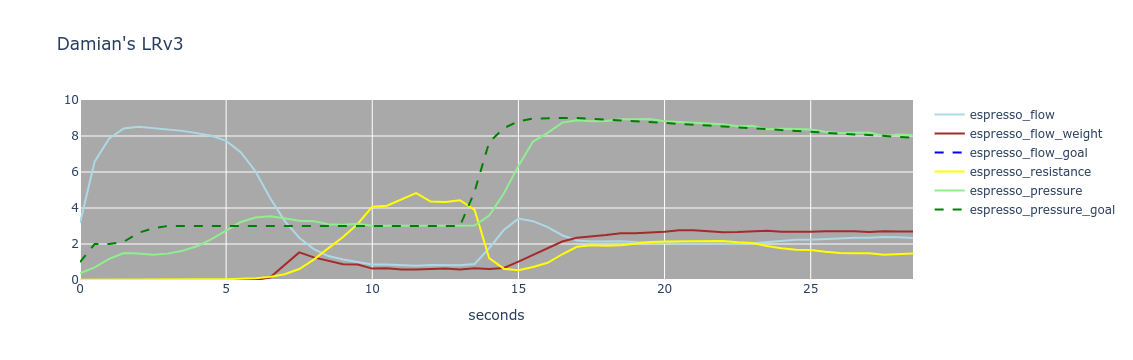

In [25]:
shot = resampled_shots.loc[shot_id]
# shot = shots_series.loc[shot_id]

df = shot.copy()
df["espresso_flow_weight"] = lowess_smoothing(shot["espresso_flow_weight"], frac=0.05)
# df["espresso_resistance"] = df["espresso_flow"] / df["espresso_flow_weight"]

visualize_shot(df, time_index=None, 
               # flow_quantiles=flow_quantiles, weight_quantiles=weight_quantiles, pressure_quantiles=pressure_quantiles,
               title=profile,)

## Plot all profiles

In [ ]:
lower_q = 0.2
upper_q = 0.8

for profile in most_popular_profiles.index.sort_values():
    samples = shots_df.index[shots_df["profile_title"]==profile]
    shot_series = shots_df.loc[samples][timeseries_cols].apply(lambda row: timeseries_to_df(row[1:].to_dict(), timeframe=row.timeframe), 
                                                               axis=1)
    shot_series = pd.concat(shot_series.to_dict(), names=["id"])
    
    groupby = shot_series.reset_index().groupby([pd.Grouper(key='seconds', freq='500L')])
    median_agg = groupby[timeseries_cols[1:]].median()

    # flow_quantiles = (groupby["espresso_flow"].quantile(lower_q), groupby["espresso_flow"].quantile(upper_q))
    # weight_quantiles = (groupby["espresso_flow_weight"].quantile(lower_q), groupby["espresso_flow_weight"].quantile(upper_q))
    # pressure_quantiles = (groupby["espresso_pressure"].quantile(lower_q), groupby["espresso_pressure"].quantile(upper_q))
    
    visualize_shot(median_agg, time_index=None, 
               # flow_quantiles=flow_quantiles, weight_quantiles=weight_quantiles, pressure_quantiles=pressure_quantiles,
               title=profile).show(renderer="jupyterlab", config={})